In [32]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from itertools import product
import optuna

In [33]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # normalize the dataset to range [-1, 1]
    transforms.RandomRotation(10),  # rotate the image randomly by 10 degrees
    transforms.RandomHorizontalFlip()  # flip the image horizontally with a 50% probability
])

# Download and load the training data
trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Create indices for training and validation splits
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)

# Define split size
split = int(0.2 * num_train)  # 20% for validation
train_idx, val_idx = indices[split:], indices[:split]

# Create samplers for training and validation
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

# Create data loaders with samplers
trainloader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
valloader = DataLoader(trainset, batch_size=64, sampler=val_sampler)

# Download and load the test data
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [34]:
# Let's check if our data is loaded correctly
images, labels = next(iter(trainloader))

print(images.shape)
print(len(trainloader))
print(labels.shape)
print(len(testloader))

# Check each sample in the dataset
missing_samples = any(img is None or lbl is None for img, lbl in trainset)

if missing_samples:
    print("Missing data detected in individual samples.")
else:
    print("No missing data found in individual samples.")

torch.Size([64, 1, 28, 28])
750
torch.Size([64])
157
No missing data found in individual samples.


In [35]:
unique_labels, counts = np.unique(trainset.targets, return_counts=True)
print(f"Unique labels: {unique_labels}")
print(f"Counts: {counts}")

print("Number of samples per digit:")
for label, count in zip(unique_labels, counts):
    print(f"Digit {label}: {count}")

# Check if the data distribution is balanced
total_samples = len(trainset.targets)
min_samples = min(counts)
max_samples = max(counts)
balance_ratio = min_samples / max_samples

print(f"\nTotal samples: {total_samples}")
print(f"Balance ratio (min/max): {balance_ratio}")

Unique labels: [0 1 2 3 4 5 6 7 8 9]
Counts: [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
Number of samples per digit:
Digit 0: 6000
Digit 1: 6000
Digit 2: 6000
Digit 3: 6000
Digit 4: 6000
Digit 5: 6000
Digit 6: 6000
Digit 7: 6000
Digit 8: 6000
Digit 9: 6000

Total samples: 60000
Balance ratio (min/max): 1.0


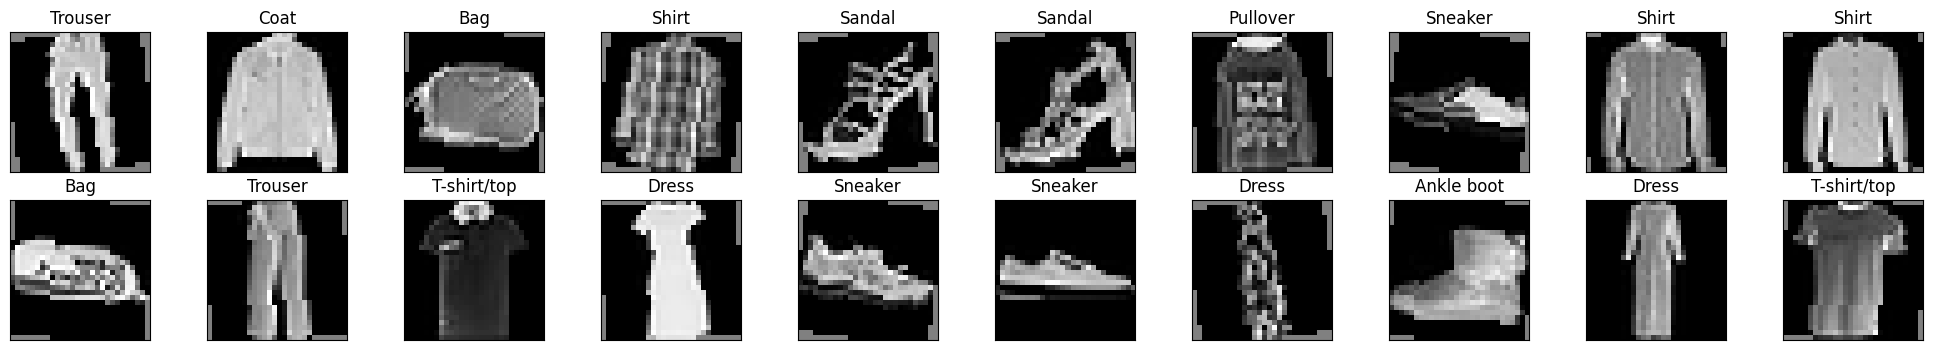

In [36]:
# Let's plot all the unique labels from the dataset
# Define the text labels
text_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(text_labels[labels[idx].item()])
plt.show()

In [37]:
class SimpleCNNImage(nn.Module):
    def __init__(self, dropout=0.45, kernel_size=3, num_classes=10):
        super(SimpleCNNImage, self).__init__()

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization added
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization added
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.bn3 = nn.BatchNorm1d(512)  # Batch normalization added
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(512, 128)
        self.bn4 = nn.BatchNorm1d(128)  # Batch normalization added
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        # Output Layer
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.flatten(x)
        x = self.dropout1(self.relu3(self.bn3(self.fc1(x))))
        x = self.dropout2(self.relu4(self.bn4(self.fc2(x))))
        x1 = x
        x = self.fc3(x)
        return x1, x

In [38]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters to tune
    dropout = trial.suggest_float('dropout', 0.3, 0.6)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_epochs = trial.suggest_int('num_epochs', 5, 20)

    # Initialize the model, criterion, and optimizer with suggested parameters
    model = SimpleCNNImage(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
        model, criterion, optimizer, trainloader, valloader, num_epochs
    )

    # Return the best validation accuracy (maximize)
    return max(valid_accuracies)

In [39]:
model_path = "./model/best_model_state.pth"
best_model = SimpleCNNImage(dropout=0.45)
criterion = nn.CrossEntropyLoss() 

In [40]:
def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=10):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            optimizer.zero_grad()
            _, outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        # Validation
        model.eval()
        running_valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        
        with torch.no_grad():
            for images, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                _, outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_valid_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()
                
        valid_losses.append(running_valid_loss / len(valid_loader))
        valid_accuracy = 100 * correct_valid / total_valid
        valid_accuracies.append(valid_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Valid Accuracy: {valid_accuracy:.2f}%")
    
    # Plotting
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [41]:
model_path = "model/best_model_state.pth"

try:
    best_model.load_state_dict(torch.load(model_path))
    best_model.eval()
except:
    # Create a study and optimize
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=1)

    # Print best parameters
    print("Best parameters found:")
    print(study.best_params)

    # Evaluate on the testing set with the best model
    best_params = study.best_params
    best_model = SimpleCNNImage(dropout=best_params['dropout'])
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
    train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
        best_model, criterion, optimizer, trainloader, valloader, best_params['num_epochs']
    )

    # Save the model state dict
    model_path = "best_model_state.pth"
    torch.save(best_model.state_dict(), model_path)
    print(f"Model state dict saved to {model_path}")

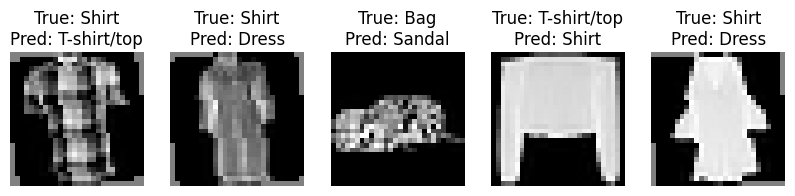

In [42]:
# Function to identify misclassified images during validation/testing
def find_misclassified_images(model, dataloader):
    model.eval()  # Set model to evaluation mode
    misclassified_images = []
    true_labels = []
    predicted_labels = []
    
    # Iterate over the dataloader
    with torch.no_grad():
        for images, labels in dataloader:
            _, outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Find misclassified images
            misclassified_mask = predicted != labels
            misclassified_images.extend(images[misclassified_mask])
            true_labels.extend(labels[misclassified_mask])
            predicted_labels.extend(predicted[misclassified_mask])
    
    return misclassified_images, true_labels, predicted_labels

# Function to visualize some of the misclassified images
def visualize_misclassified_images(misclassified_images, true_labels, predicted_labels, class_names, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(misclassified_images))):
        image = misclassified_images[i].cpu().numpy().squeeze()
        true_label = class_names[true_labels[i].cpu().item()]
        predicted_label = class_names[predicted_labels[i].cpu().item()]
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'True: {true_label}\nPred: {predicted_label}')
        plt.axis('off')
    plt.show()

# Find misclassified images in the validation set
misclassified_images, true_labels, predicted_labels = find_misclassified_images(best_model, valloader)

# Define class names for FashionMNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Visualize some of the misclassified images
visualize_misclassified_images(misclassified_images, true_labels, predicted_labels, class_names, num_images=5)

In [43]:
# Evaluate on the testing set
best_model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in tqdm(testloader, desc="Testing"):
        images = images.view(-1, 1, 28, 28)
        images = images.float()
        _, outputs = best_model(images)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Test Loss: {test_loss / len(testloader):.4f}, Test Accuracy: {test_accuracy:.2f}%")


Testing: 100%|██████████| 157/157 [00:03<00:00, 47.94it/s]

Test Loss: 0.2550, Test Accuracy: 90.47%


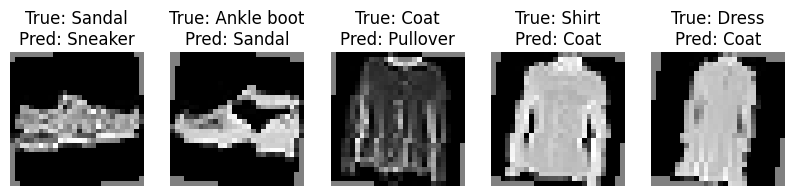

In [44]:
# Find misclassified images in the validation set
misclassified_images, true_labels, predicted_labels = find_misclassified_images(best_model, testloader)

# Define class names for FashionMNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Visualize some of the misclassified images
visualize_misclassified_images(misclassified_images, true_labels, predicted_labels, class_names, num_images=5)

In [45]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Function to extract embeddings
def extract_embeddings(model, image_train_loader):
    embeddings = []
    labels = []
    with torch.no_grad():
        for image_data, image_labels in tqdm((image_train_loader), desc=f"Extracting"):
            image_input = image_data.view(-1, 1, 28, 28).float()
            image_embedding, _ = model(image_input)
            embeddings.append(image_embedding)
            labels.append(image_labels)
    embeddings = torch.cat(embeddings)
    labels = torch.cat(labels)
    return embeddings, labels

# Extract embeddings for training data
train_embeddings, train_labels = extract_embeddings(best_model, trainloader)

Extracting: 100%|██████████| 750/750 [00:15<00:00, 47.45it/s]


Number of components for 90% explained variance: 8


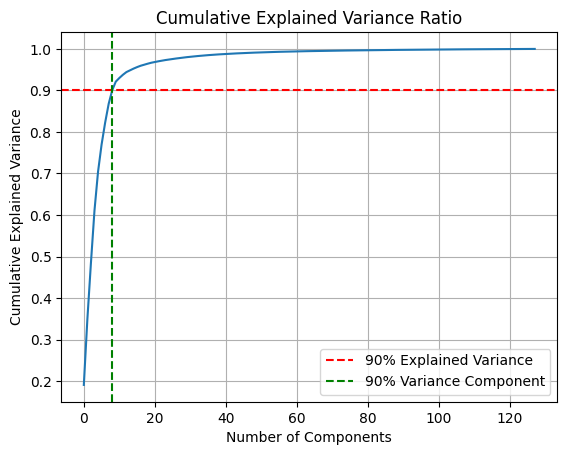

In [46]:
# Fit PCA
pca = PCA()
pca.fit(train_embeddings)

# Calculate cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the index where cumulative explained variance ratio first surpasses 0.9
index_90_percent = np.argmax(cumulative_variance >= 0.9)
print(f"Number of components for 90% explained variance: {index_90_percent}")

# Plot cumulative explained variance ratio
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Ratio')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Explained Variance')
plt.axvline(x=index_90_percent, color='g', linestyle='--', label='90% Variance Component')
plt.grid(True)
plt.legend()
# output_path = os.path.join(output_dir, 'Cumulative Explained Variance Ratio Image.png')
# plt.savefig(output_path)
plt.show()

In [47]:
# Function to apply PCA
def apply_pca(embeddings, n_components):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(embeddings)
    return pca_result

# Apply PCA
num_components = 8  # You can choose any number of components
pca_embeddings = apply_pca(train_embeddings, num_components)

In [48]:
print("pca_embeddings data type:", type(pca_embeddings))
print("pca_embeddings shape:", pca_embeddings.shape)

# Check the data type and shape of labels
train_labels_np = train_labels.numpy()
print("labels data type:", type(train_labels_np))
print("labels shape:", train_labels_np.shape)

pca_embeddings data type: <class 'numpy.ndarray'>
pca_embeddings shape: (48000, 8)
labels data type: <class 'numpy.ndarray'>
labels shape: (48000,)


/Users/jaydeepradadiya/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


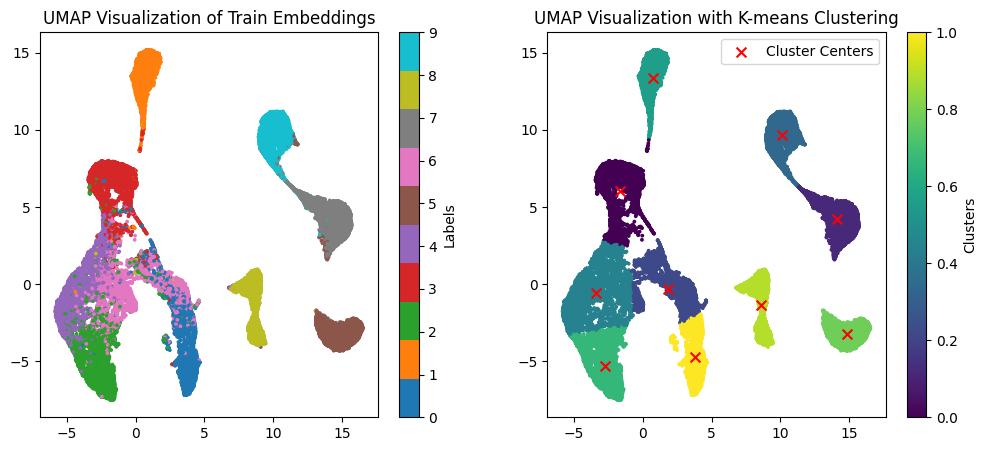

In [49]:
import umap.umap_ as umap

# Function to apply UMAP, visualize embeddings, and perform k-means clustering
def visualize_umap_with_clustering(embeddings, labels, num_clusters):
    # Apply UMAP for dimensionality reduction
    umap_result = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.0, metric='cosine').fit_transform(embeddings)
    
    # Plot UMAP embeddings
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(umap_result[:, 0], umap_result[:, 1], c=labels, cmap='tab10', s=3)
    plt.title('UMAP Visualization of Train Embeddings')
    plt.colorbar(label='Labels')
#     output_path = os.path.join(output_dir, 'UMAP Visualization of Train Embeddings Image.png')
#     plt.savefig(output_path)
    
    # Apply k-means clustering
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(umap_result)
    cluster_centers = kmeans.cluster_centers_  # Get cluster centers
    
    # Plot UMAP embeddings with cluster assignments and cluster centers
    plt.subplot(1, 2, 2)
    plt.scatter(umap_result[:, 0], umap_result[:, 1], c=cluster_labels, cmap='viridis', s=3)
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=50, label='Cluster Centers')
    plt.title('UMAP Visualization with K-means Clustering')
    plt.colorbar(label='Clusters')
    plt.legend()
#     output_path = os.path.join(output_dir, 'UMAP Visualization with K-means Clustering Image.png')
#     plt.savefig(output_path)
    plt.show()

# Assuming you have your embeddings stored in pca_embeddings and labels in train_labels_np
# Also, assuming the number of clusters is 10
visualize_umap_with_clustering(pca_embeddings, train_labels_np, num_clusters=10)